In [93]:
%pip install flatten_json pymongo pandas sklearn matplotlib np
import pandas as pd
import pymongo
import sklearn
from flatten_json import flatten
import matplotlib.pyplot as plt
import numpy as np

  Preparing metadata (setup.py) ... done
Using legacy 'setup.py install' for np, since package 'wheel' is not installed.
  Running setup.py install for np ... done
Note: you may need to restart the kernel to use updated packages.


In [96]:
mongo_client = pymongo.MongoClient("mongodb://localhost:27017/")
mongo_database = mongo_client["tft_data"]
mongo_container = mongo_database["challenger"]
all_data = list(mongo_container.find().limit(10))

In [97]:
df = pd.json_normalize(all_data, ["info", "participants"], ["metadata"])

def trait_object_array_to_trait_array(trait_object_array):
   return [f"{trait['name']}_{trait['num_units']}_units" for trait in trait_object_array]

def units_object_array_to_unit_array(unit_object_array):
   unit_array = []  
   for unit in unit_object_array:
      items = ""
      for index, item in enumerate(unit['itemNames']):
         items += f"+item{index + 1}{item.replace('TFT_Item', '')}"
      unit_array.append(f"tier_{unit['tier']}_{unit['character_id']}{items}")
   return unit_array

def prefix_augements_with_order(augments):
   return [f"{index + 1}_{augment}" for index, augment in enumerate(augments)]

def get_match_id(metadata):
   return metadata['match_id']

df['traits'] = df['traits'].apply(trait_object_array_to_trait_array)
df['units'] = df['units'].apply(units_object_array_to_unit_array)
df['match_id'] = df['metadata'].apply(get_match_id)
df['augments'] = df['augments'].apply(prefix_augements_with_order)

from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)

df = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('augments')),
                index=df.index,
                columns=mlb.classes_)).join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('traits')),
                index=df.index,
                columns=mlb.classes_)).join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('units')),
                index=df.index,
                columns=mlb.classes_))

df['played_with_parner'] = np.where(np.isnan(df['partner_group_id']), False, True)

df = df.drop(columns=['metadata', 'traits', 'units'])

df.to_csv("out.csv", index=False)
df

/tmp/ipykernel_42551/1045284455.py:48: FutureWarning: The behavior of .astype from SparseDtype to a non-sparse dtype is deprecated. In a future version, this will return a non-sparse array with the requested dtype. To retain the old behavior, use `obj.astype(SparseDtype(dtype))`
  df.to_csv("out.csv", index=False)


,gold_left,last_round,level,partner_group_id,placement,players_eliminated,puuid,time_eliminated,total_damage_to_players,companion.content_ID,...,tier_3_TFT7_Varus+item1_RapidFireCannon+item2TFT7_Item_MageEmblemItem+item3_StatikkShiv,tier_3_TFT7_Varus+item1_UnstableConcoction,tier_3_TFT7_Vladimir,tier_3_TFT7_Vladimir+item1_ChainVest,tier_3_TFT7_Vladimir+item1_Chalice+item2_PowerGauntlet+item3_BrambleVest,tier_3_TFT7_Vladimir+item1_ThiefsGloves+item2_WarmogsArmor+item3_GargoyleStoneplate,tier_3_TFT7b_Heimerdinger,tier_3_TFT7b_Volibear+item1_GuardianAngel+item2_TitansResolve+item3_RedBuff,tier_3_TFT7b_Volibear+item1_RedBuff+item2_WarmogsArmor+item3_TitanicHydra,played_with_parner
0,0,35,8,1.0,6,0,4vDKWDyLDh_efpYuChux5T41mLWrC5F5c-HQlmUDIqLXA4...,2154.151611,50,68f8391d-de9d-44ff-85cf-30eb4b01da95,...,0,0,0,0,0,0,0,0,0,True
1,0,35,8,1.0,5,0,D0QuHbLzIsV0WwhrmsvRxZtqCdCiexXWD3UQpqmO4XAE5G...,2166.960205,56,52fb7d7d-00ac-4464-ba08-93dbe67ddba9,...,0,0,0,0,0,0,0,0,0,True
2,18,38,8,2.0,2,3,_6YHT8kAvPPIUhjTgUQdPVBKLHZhBEJUx2Oa47UPCFQX8U...,2333.103027,63,4b19b861-a128-484b-b993-fa023e150da7,...,0,0,0,0,0,0,0,0,0,True
3,0,38,8,2.0,1,2,Rv0bOzEeDk1Afavn2a0nuFXhrhh2cEdWXxOw-cQyxGrk84...,2333.103027,71,fa1a8a0b-c79a-41f9-a168-a6e249af52b7,...,0,0,0,0,0,0,0,0,0,True
4,2,34,9,3.0,8,0,Az2i--gJndrpNpmwubU6nMFi54cAGFlmRG085xfF-Ehx6X...,2064.495850,35,d86209d9-360c-42df-988d-fb8bf21a6733,...,0,0,0,0,0,0,0,0,0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,1,41,9,NaN,1,2,_6YHT8kAvPPIUhjTgUQdPVBKLHZhBEJUx2Oa47UPCFQX8U...,2372.864014,224,4b19b861-a128-484b-b993-fa023e150da7,...,0,0,0,0,0,0,0,0,0,False
76,6,28,8,NaN,7,0,3dJnR7WMLWd_EMcKjoExid4R0IHzzxAgahQoWXKHy-ZiPE...,1685.866577,67,b890d4df-181a-43da-861d-99a72afbc602,...,0,0,0,0,0,0,0,0,0,False
77,0,27,8,NaN,8,0,lAoe05UoCe_Ug6ZOhUSNNSIttA2i0YMvDMrF6bX3utMFwV...,1614.434448,61,487f2d34-2e0a-4bcb-9913-7178ecc2b2ef,...,0,0,0,0,0,0,0,0,0,False
78,0,38,9,NaN,3,1,i6NXpT_jlJFEd3xU9aNPa7NkSIfKeDZschsJphabGLN09a...,2218.509033,108,d7a902cf-e889-40c1-a553-350554767582,...,0,0,0,0,0,0,0,0,0,False


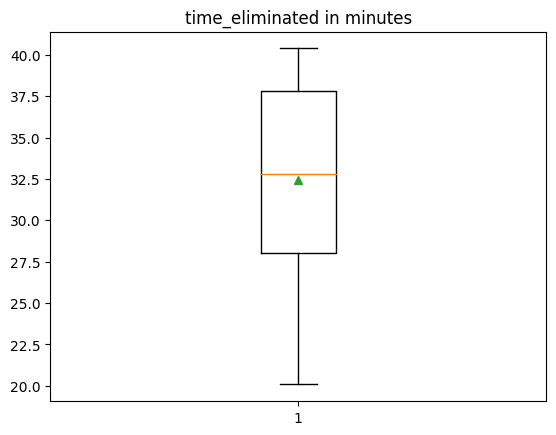

In [130]:
fig1, ax1 = plt.subplots()
ax1.set_title('time_eliminated in minutes')
bp = ax1.boxplot(df["time_eliminated"]/60, showmeans = True)


Text(0.5, 0, 'Time in minutes')

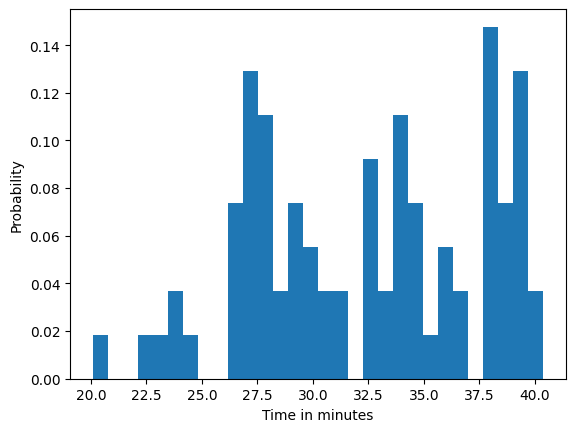

In [123]:
hist = plt.hist(df["time_eliminated"]/60, density=True, bins=30) 
plt.ylabel('Probability')
plt.xlabel('Time in minutes')


False    72
True      8
Name: played_with_parner, dtype: int64

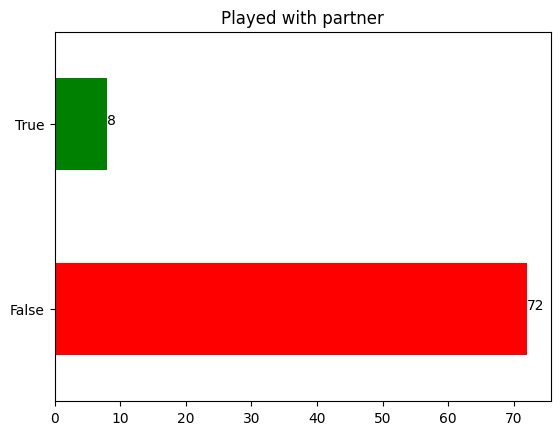

In [122]:
from turtle import color


df["played_with_parner"].value_counts().plot(kind='barh', title='Played with partner', color=['red', 'green'])
# add values to chart
for i, v in enumerate(df["played_with_parner"].value_counts()): 
    plt.text(v, i , str(v), color='black')

df["played_with_parner"].value_counts()

4b19b861-a128-484b-b993-fa023e150da7    10
Name: companion.content_ID, dtype: int64

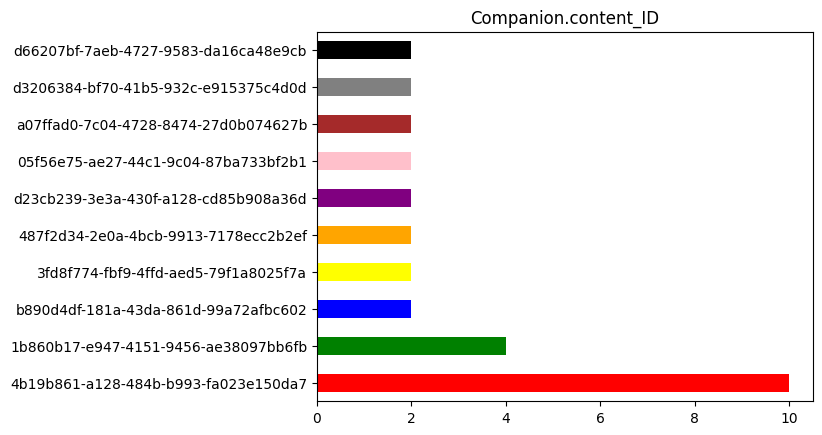

In [132]:
#plot historagm for top 10 companion.content_ID
df["companion.content_ID"].value_counts().head(10).plot(kind='barh', title='Companion.content_ID', color=['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'pink', 'brown', 'grey', 'black'])
df["companion.content_ID"].value_counts().head(1)